The following dataset contains 1m rows of http response data from a web crawler, with the following schema:

hostnameHash - this is a hash of the hostname of the http request url.

pageGuid - this is a unique ID assigned to the http response received

parentPageGuid - the unique ID of the parent page of this request (more explanation on this below).

httpResponseCode - the http response code received

responseBodyMD5 - the md5 hash of the response body received

responseBodySize - the size, in bytes, of the response body

contentType - the contents of the content type header


In this web crawler, every http response is assigned a unique ID.  If a http response loads dependent requests (e.g., if we make a request to http://www.google.com, the response may include an additional request/response from https://www.google.com/images/nav_logo242.png) then those dependent requests will be assigned a parent page guid that matches the guid of the calling page.  If the parentPageGuid field is null, that means that the corresponding response came from a direct request (i.e., not loaded from some other page).  If the hostnameHash field is null, that means that we were unable to parse the url for some unknown reason.

Suppose you want to understand more about these hosts and their dependent requests.  What can you derive from this data?  Some ideas:

* what does the distribution of dependent requests across hosts look like?  What other basic statistics might be interesting to describe this data?
* can you classify hosts into reasonable "types" based on these features?  Conceivably, www.google.com will look different from www.nytimes.com, but perhaps www.google.com and www.bing.com are similar?

* are there interesting correlations between dependent requests?

* any other interesting question you might want to answer...

 

Please time-box your work to no more than 3 hours.  If you don't have time to generate results, please describe what you've done so far and the approach you would use if you were to invest more time into the problem.

 

Dataset link: https://drive.google.com/open?id=1l_fzmf1ncpm45EIwk4KZojPtT3uGscCj

In [46]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas_profiling as pdp
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('./data/rb_md5s.txt',delimiter='\t')

In [3]:
df.columns=('hostnameHash','parentPageGuid','pageGuid','httpResponseCode','responseBodyMD5','responseBodySize','contentType')

In [4]:
df.to_pickle('./pickle/df1.pkl')

In [5]:
df=pd.read_pickle('./pickle/df1.pkl')

In [6]:
df.head()

,hostnameHash,parentPageGuid,pageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
0,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,e998b51a-e117-4e28-8bc2-f3aa52b6cca9,301,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
1,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,b80e939c-ec86-4ba0-a21b-a05f47d11f69,302,07b4511278d33e0a152458bc56121059,128.0,text/html
2,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,14d39101-c2ac-46bc-bde9-fbb5822fc41c,200,d681413ffee243c992957f487973ad36,13381.0,text/javascript
3,131a460e5e56b32eb51e09395cb62074,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,d9ad296b-5ea3-4964-bd15-e9e5fe52b873,200,687707a77e06dbaecaaa688f8485bad1,561539.0,application/javascript
4,131a460e5e56b32eb51e09395cb62074,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,b188df1f-03e5-4b86-961e-0283120c1edd,200,376728432654e63a857795e2d2738d47,188011.0,text/css


In [7]:
df = df.dropna(subset=['hostnameHash'])

In [153]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 986330 entries, 0 to 999998
Data columns (total 8 columns):
hostnameHash              986330 non-null object
parentPageGuid            967521 non-null object
pageGuid                  986330 non-null object
httpResponseCode          986330 non-null int64
responseBodyMD5           985057 non-null object
responseBodySize          806484 non-null float64
contentType               939102 non-null object
contentType_list_lower    939102 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 67.7+ MB


In [9]:
contentType_list = df.contentType.unique()
contentType_list
for c in contentType_list:
    print(c,type(c))
print(len(contentType_list))

nan <class 'float'>
text/html <class 'str'>
text/javascript <class 'str'>
application/javascript <class 'str'>
text/css <class 'str'>
application/vnd.ms-fontobject <class 'str'>
application/font-woff <class 'str'>
application/x-font-ttf <class 'str'>
image/png <class 'str'>
image/gif <class 'str'>
image/svg+xml <class 'str'>
image/jpeg <class 'str'>
image/vnd.microsoft.icon <class 'str'>
image/x-icon <class 'str'>
application/x-javascript <class 'str'>
application/json <class 'str'>
application/font-woff2 <class 'str'>
application/ecmascript <class 'str'>
font/woff <class 'str'>
text/plain <class 'str'>
application/octet-stream <class 'str'>
font/ttf <class 'str'>
image/JPEG <class 'str'>
image/webp <class 'str'>
application/font-sfnt <class 'str'>
font/woff2 <class 'str'>
text/json <class 'str'>
application/xml <class 'str'>
font/eot <class 'str'>
application/x-font-woff <class 'str'>
font/truetype <class 'str'>
application/x-woff <class 'str'>
image/jpg <class 'str'>
image/bmp <class

In [138]:
df.contentType_list_lower.value_counts()

image/png                                   205131
text/html                                   132663
image/gif                                   118703
image/jpeg                                   75227
text/javascript                              66921
application/javascript                       65428
font/woff2                                   41576
image/svg+xml                                40362
text/css                                     38651
application/x-javascript                     31107
text/plain                                   26699
application/vnd.ms-fontobject                21167
application/octet-stream                     12113
application/font-woff                        10017
font/woff                                     7099
application/json                              7031
image/x-icon                                  5984
application/x-font-ttf                        4890
application/x-font-woff                       4258
font/ttf                       

In [10]:
df[df.contentType.isna()]

,hostnameHash,parentPageGuid,pageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
0,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,e998b51a-e117-4e28-8bc2-f3aa52b6cca9,301,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
36,131a460e5e56b32eb51e09395cb62074,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,3db4b602-5f3f-4a37-bd3c-1106c28ea7d8,200,818f244bb227df9f070b23ec6d7752e8,4286.0,NaN
108,d563b1644494e8e31240eaf58c1c653e,18a7c358-f774-4ec8-a241-f8d435e9ed04,a091526c-f081-47e0-869a-78fb8aab8056,302,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
276,aa1ab627915bd04f8ba038134e3ed3b1,d8eee62b-0fcf-47d0-852b-c135c99e667d,9ed689a0-bc95-4165-86fa-962a7b630ca8,301,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
277,aa1ab627915bd04f8ba038134e3ed3b1,d8eee62b-0fcf-47d0-852b-c135c99e667d,35f64350-af7e-48f8-b06e-50b885a053aa,301,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
312,131a460e5e56b32eb51e09395cb62074,d8eee62b-0fcf-47d0-852b-c135c99e667d,d3746454-563d-4ae8-b313-90a0fc6c7384,200,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
449,6ff672fc0eb3b0685cef5db1719ff564,f2d3243d-9065-41ad-bca1-d435bcbea10c,d182e49b-52ef-4c0b-827f-14d1d7d45324,302,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
479,a2b37569a1a5634daf93780df5d6eaa6,2b6bf194-2b8a-42cc-ae90-1db8143f928f,a01ad098-6b51-46f8-be4e-ec7cfaaab099,204,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
489,665dcec24b8083ba257c7a51c5247576,aeca7b48-a25f-41ae-8f99-b4519a1ff8e9,7c185bda-6bf8-46ed-a6b1-bb018e627b1c,200,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
494,4e56999de4f7e1238b8fdbd891219bed,aeca7b48-a25f-41ae-8f99-b4519a1ff8e9,d75180c4-996d-4e6a-ad11-0cade8a93fb0,204,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN


Why is the initial parentPageGuid missing

In [149]:
df[df.parentPageGuid=='1a6c0d62-b3b6-4bb2-aaed-f389f7771d60'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 91 entries, 0 to 90
Data columns (total 8 columns):
hostnameHash              91 non-null object
parentPageGuid            91 non-null object
pageGuid                  91 non-null object
httpResponseCode          91 non-null int64
responseBodyMD5           91 non-null object
responseBodySize          90 non-null float64
contentType               89 non-null object
contentType_list_lower    89 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 6.4+ KB


In [146]:
df[df.parentPageGuid=='1a6c0d62-b3b6-4bb2-aaed-f389f7771d60'].hostnameHash.value_counts()

131a460e5e56b32eb51e09395cb62074    70
59746a0206e4d6dbffaa21c420e4427f    18
7905d1c4e12c54933a44d19fcd5f9356     3
Name: hostnameHash, dtype: int64

In [152]:
df[df.parentPageGuid=='1a6c0d62-b3b6-4bb2-aaed-f389f7771d60'].pageGuid.value_counts()

ed8f7295-295e-40c6-8d69-3ffcabd51537    1
2fd92eb7-9914-4fc7-bfa5-6abf70ecd292    1
11b63054-5727-4710-87f6-7849fb6ef456    1
4cd62d45-f31d-4d64-ac74-206b228fe972    1
a16ca64d-4f56-44c0-b695-1b68c478e245    1
d9ad296b-5ea3-4964-bd15-e9e5fe52b873    1
1f349e33-dfda-4b2f-8620-3abeca7a075b    1
acb621c9-028f-43c1-bdfe-e4cc7ced6437    1
b6c6c6df-e0b5-4eed-898b-d0d093c90186    1
58c8d46e-d2b6-41b1-add3-edba23013f6a    1
550c7e61-3419-41fd-90ad-992ab6354697    1
b3b5b7cd-cb03-4492-af7e-3274b15caa8c    1
a96dddf3-7c2b-4ee1-984b-55e1d8865af7    1
ada5ac89-fa96-41ca-8942-0d335336b891    1
4ef0d1e6-96db-484a-80df-d958dbe27adb    1
fadc5b2d-a509-445e-b813-9ebf9c0f6252    1
7cd2f665-b139-4bd7-b59b-0c0e17dde4d2    1
d6906106-2e0b-4ae2-ac6f-503b3d8533bd    1
f9b612b3-1ad2-4666-ab95-5f24fafff395    1
e9a9822e-231d-4582-8905-c619fae7cd53    1
32f477e7-a3c1-45ad-a5de-b6141c6b2896    1
6d13b5d1-c7ab-4669-b26f-4f35ff4496bd    1
ffe84bcd-dee5-477d-9ed9-ed38befe441a    1
9bde5c20-6eb8-457e-bc14-4704177d8a

In [11]:
df[df.hostnameHash=='7905d1c4e12c54933a44d19fcd5f9356']

,hostnameHash,parentPageGuid,pageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
0,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,e998b51a-e117-4e28-8bc2-f3aa52b6cca9,301,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
1,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,b80e939c-ec86-4ba0-a21b-a05f47d11f69,302,07b4511278d33e0a152458bc56121059,128.0,text/html
2,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,14d39101-c2ac-46bc-bde9-fbb5822fc41c,200,d681413ffee243c992957f487973ad36,13381.0,text/javascript
92,7905d1c4e12c54933a44d19fcd5f9356,d09c7f28-6edd-4fe0-9c1f-aefa12b17569,15a43e4b-84de-42fb-ba97-e3d8157b371e,200,630d203cdeba06df4c0e289c8c8094f6,1150.0,image/x-icon
275,7905d1c4e12c54933a44d19fcd5f9356,NaN,d8eee62b-0fcf-47d0-852b-c135c99e667d,200,de6714530e8c560c13ebf0e8bb537f7e,499281.0,text/html
278,7905d1c4e12c54933a44d19fcd5f9356,d8eee62b-0fcf-47d0-852b-c135c99e667d,802ce12d-d36f-4e43-91f1-cf1db3ab7668,200,c40a91cd6fcc2fb59669365d459d1a60,13020.0,text/javascript
428,7905d1c4e12c54933a44d19fcd5f9356,7556a270-c74a-4681-a198-ace934c11b23,e83e5f2e-7010-48ae-b732-a604f6bf2e5c,200,630d203cdeba06df4c0e289c8c8094f6,1150.0,image/x-icon
2176,7905d1c4e12c54933a44d19fcd5f9356,NaN,11952a57-9902-4e9c-95f5-a0e02fdf5d2d,200,05ef0f0b0cc4180ee8c49f785da19120,243972.0,text/html
2177,7905d1c4e12c54933a44d19fcd5f9356,11952a57-9902-4e9c-95f5-a0e02fdf5d2d,67d01ddf-f34b-487c-98fa-80b3406cf689,301,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN
2178,7905d1c4e12c54933a44d19fcd5f9356,11952a57-9902-4e9c-95f5-a0e02fdf5d2d,ddb523e9-c049-44cf-a470-8231d53e1e91,200,19522c02a5dde29b5c264365990812f1,12323.0,text/javascript


In [12]:
new_list=[]
for c in contentType_list:
    if type(c) == str:
        new_list.append(c.lower())
    else:
        new_list.append(c)
print('contentTypes:',len(set(contentType_list)))
print('contentTypes ignoring case:',len(set(new_list)))

contentTypes: 143
contentTypes ignoring case: 133


In [13]:
df['contentType_list_lower'] = [c.lower() if type(c)==str else c for c in df['contentType']]
len(df.contentType_list_lower.unique())

133

In [14]:
df[df.parentPageGuid.isna()].groupby('hostnameHash').count()

,parentPageGuid,pageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType,contentType_list_lower
hostnameHash,,,,,,,
000704a3e488015d32cc64a86dc32310,0,1,1,1,0,1,1
000758a353fa674f968ab5d837170129,0,2,2,2,2,2,2
00152d5fbe4125b51f6f9f46b862ecd3,0,1,1,1,1,1,1
0021e2d1a666100a9ca1d9d99b98a068,0,1,1,1,1,1,1
003eb7d4255dad4f0c5d7f3f01f2b2ab,0,1,1,1,1,1,1
0049c7f5ab31449e494af547955e78e0,0,2,2,2,2,2,2
005371b8ff8cb3af3208c4e8213d2287,0,1,1,1,1,1,1
005b54dc95d39e9285ede8d1a820a510,0,2,2,2,2,2,2
005e4d66d9a71e9a1c16c81d5e0424c4,0,1,1,1,1,1,1


In [100]:
df_dummies.head()

,hostnameHash,parentPageGuid,pageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType_list_lower,"contentType_('image/jpeg', None)",contentType_Content-Type: image/gif,contentType_Content-type: image/png,...,contentType_text/xml,contentType_unknown,contentType_unknown/unknown,contentType_video/MP2T,contentType_video/mp4,contentType_video/webm,contentType_video/x-flv,contentType_x-font/eot,contentType_x-font/ttf,contentType_x-font/woff
0,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,e998b51a-e117-4e28-8bc2-f3aa52b6cca9,301,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,b80e939c-ec86-4ba0-a21b-a05f47d11f69,302,07b4511278d33e0a152458bc56121059,128.0,text/html,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,14d39101-c2ac-46bc-bde9-fbb5822fc41c,200,d681413ffee243c992957f487973ad36,13381.0,text/javascript,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,131a460e5e56b32eb51e09395cb62074,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,d9ad296b-5ea3-4964-bd15-e9e5fe52b873,200,687707a77e06dbaecaaa688f8485bad1,561539.0,application/javascript,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,131a460e5e56b32eb51e09395cb62074,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,b188df1f-03e5-4b86-961e-0283120c1edd,200,376728432654e63a857795e2d2738d47,188011.0,text/css,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
df_dummies = pd.get_dummies(df,columns=['contentType'])

In [125]:
df_dummies.columns.values

In [125]:
columns_to_sum = ["contentType_('image/jpeg', None)",
       'contentType_Content-Type: image/gif',
       'contentType_Content-type: image/png', 'contentType_Image/GIF',
       'contentType_Image/Jpeg', 'contentType_Image/gif',
       'contentType_None', 'contentType_application',
       'contentType_application/amazonui-streaming-json',
       'contentType_application/atom+xml',
       'contentType_application/binary', 'contentType_application/cgi',
       'contentType_application/ecmascript',
       'contentType_application/font-eot',
       'contentType_application/font-otf',
       'contentType_application/font-sfnt',
       'contentType_application/font-ttf',
       'contentType_application/font-woff',
       'contentType_application/font-woff2',
       'contentType_application/hal+json',
       'contentType_application/javascript', 'contentType_application/js',
       'contentType_application/json', 'contentType_application/msword',
       'contentType_application/ocsp-response',
       'contentType_application/octect-stream',
       'contentType_application/octet-stream',
       'contentType_application/pdf', 'contentType_application/pkix-crl',
       'contentType_application/postscript',
       'contentType_application/rss+xml', 'contentType_application/save',
       'contentType_application/vnd.android.package-archive',
       'contentType_application/vnd.api+json',
       'contentType_application/vnd.apple.mpegurl',
       'contentType_application/vnd.geo+json',
       'contentType_application/vnd.maxmind.com-country+json',
       'contentType_application/vnd.ms-cab-compressed',
       'contentType_application/vnd.ms-fontobject',
       'contentType_application/vnd.ms-opentype',
       'contentType_application/vnd.oasis.opendocument.formula-template',
       'contentType_application/vnd.openxmlformats-officedocument.wordprocessingml.document',
       'contentType_application/vnd.sun.wadl+xml',
       'contentType_application/woff2', 'contentType_application/x-123',
       'contentType_application/x-amz-json-1.1',
       'contentType_application/x-chrome-extension',
       'contentType_application/x-font-opentype',
       'contentType_application/x-font-otf',
       'contentType_application/x-font-truetype',
       'contentType_application/x-font-ttf',
       'contentType_application/x-font-woff',
       'contentType_application/x-font-woff2',
       'contentType_application/x-gzip',
       'contentType_application/x-httpd-php',
       'contentType_application/x-javascript',
       'contentType_application/x-js',
       'contentType_application/x-mpegURL',
       'contentType_application/x-mpegurl',
       'contentType_application/x-msdos-program',
       'contentType_application/x-msdownload',
       'contentType_application/x-shockwave-flash',
       'contentType_application/x-unknown',
       'contentType_application/x-unknown-content-type',
       'contentType_application/x-woff',
       'contentType_application/x-www-form-urlencoded',
       'contentType_application/xml', 'contentType_application/zip',
       'contentType_applicatoin/x-font-woff2', 'contentType_audio/mpeg',
       'contentType_audio/webm', 'contentType_audio/x-wav',
       'contentType_binary/octet-stream', 'contentType_content/fonts',
       'contentType_font/eot', 'contentType_font/opentype',
       'contentType_font/otf', 'contentType_font/truetype',
       'contentType_font/ttf', 'contentType_font/woff',
       'contentType_font/woff2', 'contentType_font/x-woff',
       'contentType_font/x-woff2', 'contentType_image%252Fjpeg',
       'contentType_image/GIF', 'contentType_image/JPEG',
       'contentType_image/Jpeg', 'contentType_image/bmp',
       'contentType_image/gif', 'contentType_image/ico',
       'contentType_image/jp2', 'contentType_image/jpeg',
       'contentType_image/jpg', 'contentType_image/pjpeg',
       'contentType_image/png', 'contentType_image/svg+xml',
       'contentType_image/vnd.microsoft.icon',
       'contentType_image/vnd.ms-photo', 'contentType_image/webp',
       'contentType_image/x-ico', 'contentType_image/x-icon',
       'contentType_image/x-ms-bmp', 'contentType_image/x-png',
       'contentType_image/x-win-bitmap',
       'contentType_image/x.fb.keyframes', 'contentType_inode/x-empty',
       'contentType_js', 'contentType_plain/text', 'contentType_png',
       'contentType_text/*', 'contentType_text/CSS',
       'contentType_text/HTML', 'contentType_text/JavaScript',
       'contentType_text/calendar', 'contentType_text/css',
       'contentType_text/html', 'contentType_text/html,application/json',
       'contentType_text/html-by-ajax', 'contentType_text/javascript',
       'contentType_text/js', 'contentType_text/json',
       'contentType_text/plain', 'contentType_text/plain charset = UTF-8',
       'contentType_text/plain charset=UTF-8', 'contentType_text/text',
       'contentType_text/txt', 'contentType_text/vnd.stripensr',
       'contentType_text/vtt', 'contentType_text/x-c',
       'contentType_text/x-component', 'contentType_text/x-js',
       'contentType_text/x-json', 'contentType_text/xml',
       'contentType_unknown', 'contentType_unknown/unknown',
       'contentType_video/MP2T', 'contentType_video/mp4',
       'contentType_video/webm', 'contentType_video/x-flv',
       'contentType_x-font/eot', 'contentType_x-font/ttf',
       'contentType_x-font/woff']

In [113]:
columns_to_count = ['hostnameHash', 'parentPageGuid', 'pageGuid', 'httpResponseCode',
       'responseBodyMD5', 'responseBodySize', 'contentType_list_lower']

In [122]:
columns_to_count

['hostnameHash',
 'parentPageGuid',
 'pageGuid',
 'httpResponseCode',
 'responseBodyMD5',
 'responseBodySize',
 'contentType_list_lower']

In [124]:
df_dummies.columns

Index(['hostnameHash', 'parentPageGuid', 'pageGuid', 'httpResponseCode',
       'responseBodyMD5', 'responseBodySize', 'contentType_list_lower',
       'contentType_('image/jpeg', None)',
       'contentType_Content-Type: image/gif',
       'contentType_Content-type: image/png',
       ...
       'contentType_text/xml', 'contentType_unknown',
       'contentType_unknown/unknown', 'contentType_video/MP2T',
       'contentType_video/mp4', 'contentType_video/webm',
       'contentType_video/x-flv', 'contentType_x-font/eot',
       'contentType_x-font/ttf', 'contentType_x-font/woff'],
      dtype='object', length=149)

In [129]:
hash_df = df_dummies.groupby('hostnameHash').count()

In [66]:
hash_df.to_pickle('./pickle/hashdf1sum.pkl')
df_dummies.to_pickle('./pickle/df_dummies1sum.pkl')

In [ ]:
hash_columns = hash_df.columns.values
type(hash_columns)
hash_columns

In [130]:
hash_df.head()

,parentPageGuid,pageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType_list_lower,"contentType_('image/jpeg', None)",contentType_Content-Type: image/gif,contentType_Content-type: image/png,contentType_Image/GIF,...,contentType_text/xml,contentType_unknown,contentType_unknown/unknown,contentType_video/MP2T,contentType_video/mp4,contentType_video/webm,contentType_video/x-flv,contentType_x-font/eot,contentType_x-font/ttf,contentType_x-font/woff
hostnameHash,,,,,,,,,,,,,,,,,,,,,
000704a3e488015d32cc64a86dc32310,0,1,1,1,0,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
000758a353fa674f968ab5d837170129,13,15,15,15,13,14,15,15,15,15,...,15,15,15,15,15,15,15,15,15,15
0007f9134e2994a9622699faa03fb446,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
000e7c78f3f74a9a932d54887cc6bb4f,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
00152d5fbe4125b51f6f9f46b862ecd3,2,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3


In [131]:
hash_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15572 entries, 000704a3e488015d32cc64a86dc32310 to fffb87ab76cf6ed77d865b7844227c27
Columns: 148 entries, parentPageGuid to contentType_x-font/woff
dtypes: int64(148)
memory usage: 17.7+ MB


In [21]:
hash_df.parentPageGuid.describe()

count    15572.000000
mean        62.132096
std        591.906701
min          0.000000
25%          1.000000
50%          3.000000
75%         16.000000
max      46514.000000
Name: parentPageGuid, dtype: float64

In [132]:
hash_df.parentPageGuid.value_counts()

1       3660
2       2446
0       1508
4        849
3        825
6        412
5        401
8        277
7        267
9        187
10       177
14       131
12       131
11       120
16       118
13       113
20       101
15        99
21        74
17        71
19        69
18        67
22        66
26        63
23        62
24        61
27        60
30        55
28        52
35        43
        ... 
700        1
1091       1
308        1
1115       1
1147       1
1179       1
1639       1
1227       1
1235       1
1363       1
1611       1
1771       1
1811       1
1915       1
300        1
316        1
684        1
348        1
356        1
2413       1
396        1
436        1
532        1
540        1
548        1
556        1
588        1
8848       1
660        1
3274       1
Name: parentPageGuid, Length: 700, dtype: int64

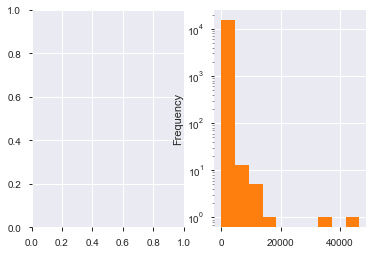

In [34]:
fig, ax = plt.subplots(1,2)
ax = hash_df.parentPageGuid.plot.hist(log=1)
ax = hash_df.parentPageGuid.plot.hist(log=10)

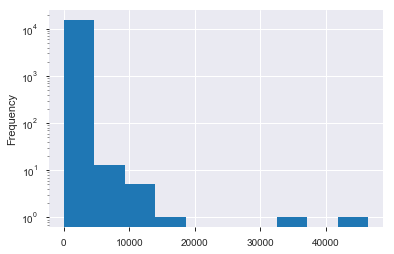

In [24]:
hash_df.parentPageGuid.plot.hist(log=10)

In [82]:
hash_df.parentPageGuid.describe()

count    15572.000000
mean        62.132096
std        591.906701
min          0.000000
25%          1.000000
50%          3.000000
75%         16.000000
max      46514.000000
Name: parentPageGuid, dtype: float64

In [57]:
hash_df[(hash_df['parentPageGuid']>=3) & (hash_df['parentPageGuid']<=16)].parentPageGuid.plot.hist(title="3rd Quartile")

In [91]:
hash_df.head()

,httpResponseCode,responseBodySize,"contentType_('image/jpeg', None)",contentType_Content-Type: image/gif,contentType_Content-type: image/png,contentType_Image/GIF,contentType_Image/Jpeg,contentType_Image/gif,contentType_None,contentType_application,...,contentType_text/xml,contentType_unknown,contentType_unknown/unknown,contentType_video/MP2T,contentType_video/mp4,contentType_video/webm,contentType_video/x-flv,contentType_x-font/eot,contentType_x-font/ttf,contentType_x-font/woff
hostnameHash,,,,,,,,,,,,,,,,,,,,,
000704a3e488015d32cc64a86dc32310,404,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000758a353fa674f968ab5d837170129,3000,1052761.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0007f9134e2994a9622699faa03fb446,800,172.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
000e7c78f3f74a9a932d54887cc6bb4f,400,86.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00152d5fbe4125b51f6f9f46b862ecd3,1509,9465.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [133]:
hash_df[(hash_df['parentPageGuid']>=3) & (hash_df['parentPageGuid']<=16)].groupby('parentPageGuid').mean()

,pageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType_list_lower,"contentType_('image/jpeg', None)",contentType_Content-Type: image/gif,contentType_Content-type: image/png,contentType_Image/GIF,contentType_Image/Jpeg,...,contentType_text/xml,contentType_unknown,contentType_unknown/unknown,contentType_video/MP2T,contentType_video/mp4,contentType_video/webm,contentType_video/x-flv,contentType_x-font/eot,contentType_x-font/ttf,contentType_x-font/woff
parentPageGuid,,,,,,,,,,,,,,,,,,,,,
3,3.192727,3.192727,3.191515,2.677576,2.963636,3.192727,3.192727,3.192727,3.192727,3.192727,...,3.192727,3.192727,3.192727,3.192727,3.192727,3.192727,3.192727,3.192727,3.192727,3.192727
4,4.426384,4.426384,4.406360,3.628975,4.134276,4.426384,4.426384,4.426384,4.426384,4.426384,...,4.426384,4.426384,4.426384,4.426384,4.426384,4.426384,4.426384,4.426384,4.426384,4.426384
5,5.625935,5.625935,5.620948,4.880299,5.246883,5.625935,5.625935,5.625935,5.625935,5.625935,...,5.625935,5.625935,5.625935,5.625935,5.625935,5.625935,5.625935,5.625935,5.625935,5.625935
6,6.422330,6.422330,6.419903,5.458738,6.012136,6.422330,6.422330,6.422330,6.422330,6.422330,...,6.422330,6.422330,6.422330,6.422330,6.422330,6.422330,6.422330,6.422330,6.422330,6.422330
7,7.367041,7.367041,7.363296,6.262172,6.835206,7.367041,7.367041,7.367041,7.367041,7.367041,...,7.367041,7.367041,7.367041,7.367041,7.367041,7.367041,7.367041,7.367041,7.367041,7.367041
8,8.498195,8.498195,8.494585,7.021661,7.841155,8.498195,8.498195,8.498195,8.498195,8.498195,...,8.498195,8.498195,8.498195,8.498195,8.498195,8.498195,8.498195,8.498195,8.498195,8.498195
9,9.208556,9.208556,9.187166,8.069519,8.352941,9.208556,9.208556,9.208556,9.208556,9.208556,...,9.208556,9.208556,9.208556,9.208556,9.208556,9.208556,9.208556,9.208556,9.208556,9.208556
10,10.355932,10.355932,10.350282,9.011299,9.694915,10.355932,10.355932,10.355932,10.355932,10.355932,...,10.355932,10.355932,10.355932,10.355932,10.355932,10.355932,10.355932,10.355932,10.355932,10.355932
11,11.241667,11.241667,11.233333,9.716667,10.650000,11.241667,11.241667,11.241667,11.241667,11.241667,...,11.241667,11.241667,11.241667,11.241667,11.241667,11.241667,11.241667,11.241667,11.241667,11.241667


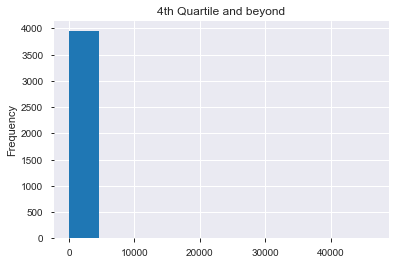

In [84]:
hash_df[(hash_df['parentPageGuid']>=16) & (hash_df['parentPageGuid']<=46514)].parentPageGuid.plot.hist(title="4th Quartile and beyond")

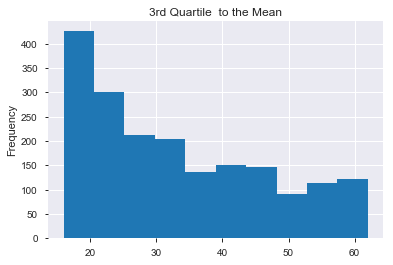

In [86]:
hash_df[(hash_df['parentPageGuid']>=16) & (hash_df['parentPageGuid']<=hash_df.parentPageGuid.mean())].parentPageGuid.plot.hist(title="3rd Quartile  to the Mean")

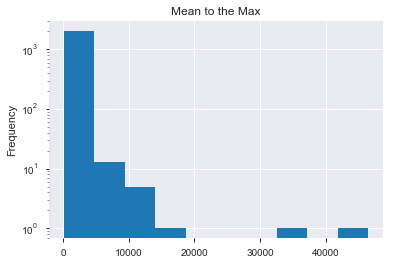

In [90]:
hash_df[(hash_df['parentPageGuid']>=hash_df.parentPageGuid.mean()) & (hash_df['parentPageGuid']<=hash_df.parentPageGuid.max())].parentPageGuid.plot.hist(title="Mean to the Max",log=10)

In [ ]:
sns.pairplot(hash_df)

(0, 4000)

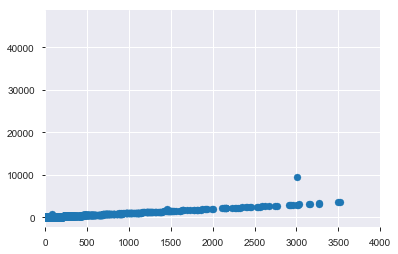

In [45]:
x=hash_df.parentPageGuid
y=hash_df.pageGuid
plt.scatter(x,y)
plt.xlim(0,4000)

In [ ]:
hash_df = df_dummies.groupby('hostnameHash')[(columns_to_count,columns_to_sum)].agg('count','sum')

In [48]:
kmeans = KMeans()

In [49]:
kmeans.fit(hash_df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [55]:
X=hash_df.copy()
print("\n5) random sample of titles in each cluster")
assigned_cluster = kmeans.transform(X).argmin(axis=1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, X.shape[0])[assigned_cluster==i]
    sample_articles = np.random.choice(cluster, 7, replace=False)
    print("cluster %d:" % i)
    for article in sample_articles:
        print("    %s" % hash_df.ix[article])



5) random sample of titles in each cluster
cluster 0:
    parentPageGuid                                     510
pageGuid                                           510
httpResponseCode                                   510
responseBodyMD5                                    510
responseBodySize                                   371
contentType_list_lower                             510
contentType_('image/jpeg', None)                   510
contentType_Content-Type: image/gif                510
contentType_Content-type: image/png                510
contentType_Image/GIF                              510
contentType_Image/Jpeg                             510
contentType_Image/gif                              510
contentType_None                                   510
contentType_application                            510
contentType_application/amazonui-streaming-json    510
contentType_application/atom+xml                   510
contentType_application/binary                     510
conten

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


ValueError: Cannot take a larger sample than population when 'replace=False'

In [86]:
requests = hash_df[['parentPageGuid']]

In [14]:
df[['hostnameHash','parentPageGuid']].groupby(['hostnameHash','parentPageGuid']).count()

Empty DataFrame
Columns: []
Index: [(000704a3e488015d32cc64a86dc32310, 2a24aa6f-f281-498c-b34e-78a174e441ef), (000758a353fa674f968ab5d837170129, 03ef9533-5019-46fc-b158-352cac804b67), (000758a353fa674f968ab5d837170129, 03f2d54d-7a96-4178-a0e3-8f54908d8a94), (000758a353fa674f968ab5d837170129, 175c1232-e080-4be6-9544-cec697bd28ed), (000758a353fa674f968ab5d837170129, 18754e3c-0ff7-42a6-bffc-f39fd4991dab), (000758a353fa674f968ab5d837170129, 31678c13-62d0-404b-8c07-18fba375dcbb), (000758a353fa674f968ab5d837170129, 3b9cf7f6-f6b0-4972-a67c-706c74986bfd), (000758a353fa674f968ab5d837170129, 44ae513d-16da-416f-89b1-94709270fadb), (000758a353fa674f968ab5d837170129, 686ee1d3-0eef-4358-b71e-cc9e300aaf09), (000758a353fa674f968ab5d837170129, 92c91896-61b7-4aab-9bb5-5869a39cb93c), (000758a353fa674f968ab5d837170129, 974f888d-cb43-47dc-b94f-658c1246b5c0), (000758a353fa674f968ab5d837170129, ce57696a-2fcd-4761-8594-f9f989b2d2d9), (000758a353fa674f968ab5d837170129, e6888321-f81c-4fe4-a92a-73bc2209adbe), (000758a353fa674f968ab5d837170129, f8a977df-33e6-42b8-aa23-3d53728b24ed), (000758a353fa674f968ab5d837170129, fc7cfb12-f729-4e22-8774-0c03c8ddd374), (000758a353fa674f968ab5d837170129, feb9ab90-88d0-450c-9629-dfe3d1a725ef), (0007f9134e2994a9622699faa03fb446, 1283b292-e493-45f2-8883-3d6914014b27), (0007f9134e2994a9622699faa03fb446, 157b34fa-aab6-4939-ac33-10d4cab91f86), (0007f9134e2994a9622699faa03fb446, b3ea426c-9c77-4b6f-a896-78905f0cbac4), (0007f9134e2994a9622699faa03fb446, fa00e59a-e0b1-4f1a-8539-652564381be3), (000e7c78f3f74a9a932d54887cc6bb4f, 99562b76-5280-4a03-93b2-dce984b31aa3), (000e7c78f3f74a9a932d54887cc6bb4f, aacef6a2-6f7e-4ec6-ae04-4392bb708e76), (00152d5fbe4125b51f6f9f46b862ecd3, 2a09d81c-42f0-4972-84a4-cacb0be2a9f7), (00152d5fbe4125b51f6f9f46b862ecd3, 30d278f5-d256-45ec-9542-4061297a25b5), (00152d5fbe4125b51f6f9f46b862ecd3, 49661479-9761-42ce-a1e9-22c28f9a2af1), (0018c5469e810975769bd2470233868f, 2e71674c-17fd-4152-a7a1-4fefe9fb3faa), (0018c5469e810975769bd2470233868f, bc90d247-d12b-4f9d-8628-6ba119905426), (001d74bb3f28aaed078c549b35420d03, 34dedce4-7eee-4559-b69d-6f92ef853689), (001d74bb3f28aaed078c549b35420d03, 75cf2220-b867-4dc2-9291-4ac969719600), (001d74bb3f28aaed078c549b35420d03, 8248240d-120f-4ff5-aeaf-13e797a0f7cc), (001d74bb3f28aaed078c549b35420d03, a281c882-9516-4538-aac1-4b2eda2d6162), (001d74bb3f28aaed078c549b35420d03, e2c888a8-5571-4168-b7bd-5d4c8161141d), (001d74bb3f28aaed078c549b35420d03, e95f6aea-190a-464f-875b-0b681e9014e8), (001dcc1adf7693e8639d1d8132b77a90, 42295d01-8b9a-4656-ba9c-caaff8a4190f), (001dcc1adf7693e8639d1d8132b77a90, 8a984937-a6f4-4a67-bc8a-6fc35423caa6), (0021e2d1a666100a9ca1d9d99b98a068, 00003fbf-bfa9-4b8a-b8e0-028cbf0a3077), (0021e2d1a666100a9ca1d9d99b98a068, 012e3181-dc86-4bfe-889b-4a632e245d29), (0021e2d1a666100a9ca1d9d99b98a068, 01612b67-0786-487c-8377-bb4d957ff3f2), (0021e2d1a666100a9ca1d9d99b98a068, 04c02b95-6f13-4581-822f-12d1d8acd30c), (0021e2d1a666100a9ca1d9d99b98a068, 0fd1f8e1-8c13-42ef-a7d4-358fe82ac5eb), (0021e2d1a666100a9ca1d9d99b98a068, 0fdaedbb-4225-4e76-ac08-7d11d68e8258), (0021e2d1a666100a9ca1d9d99b98a068, 157f3c17-9347-4611-b2cb-f873bfbd664f), (0021e2d1a666100a9ca1d9d99b98a068, 17742137-0299-4a85-bb1b-ed1f55a1e81a), (0021e2d1a666100a9ca1d9d99b98a068, 179e49fd-9104-4012-8524-12689dde59b2), (0021e2d1a666100a9ca1d9d99b98a068, 236a2d81-1770-4927-a21c-2050023e618b), (0021e2d1a666100a9ca1d9d99b98a068, 23dcc09a-d3c5-4502-8981-d53f308b9276), (0021e2d1a666100a9ca1d9d99b98a068, 26a8c130-1179-4923-b7cd-33d8b6eb517d), (0021e2d1a666100a9ca1d9d99b98a068, 29acccf2-3a56-4bb3-8e2a-81766b3c5c56), (0021e2d1a666100a9ca1d9d99b98a068, 2bfb0262-b6bc-447f-aa55-242146b53847), (0021e2d1a666100a9ca1d9d99b98a068, 2d730557-8dc9-4811-9511-e30889446105), (0021e2d1a666100a9ca1d9d99b98a068, 2e5d9beb-32a4-4cb2-a3ad-2016dac367b6), (0021e2d1a666100a9ca1d9d99b98a068, 36975fa4-ca53-4311-acd6-915a73099bba), (0021e2d1a666100a9ca1d9d99b98a068, 3743073f-0818-4f22-9c1c-bb452e3100b1), (0021e2d1a666100a9ca1d9d99b98a068, 3774bd9

In [12]:
df.hostnameHash.value_counts()

cd1a781f134611f5e4cc24f76562bb7d    46514
131a460e5e56b32eb51e09395cb62074    36243
6ecf85dc29265a5041fc6ba07dd5b2ab    15798
c948dd7a61887edf9074a9f8c6461e34    12893
5804529ee4cfd3f4b630fa1e79e8637c    11271
014d64ec8e2e48a9ea5aa54062bc62c9    10541
0a137b375cc3881a70e186ce2172c8d1     9986
c333f8dafc080266b345002a8a5a5fb5     9576
576b67be8c1de540d053ad568a27af45     9469
59746a0206e4d6dbffaa21c420e4427f     8848
c4240f370111de1ec5203760b2159a3e     8450
3ebc7eff723a1d6549ea96e9d3779b0b     7931
d2153a21c926417514a224f8abca00f1     7347
e845cbdc3785b1a67978cbc5a146a168     7058
6b1f4aeeb2f1c8a68c0e46aec93d550e     6458
d5c5c85e129eb37139f8528b5c71ec3f     5700
f1b57ef2cf3ce2c546da65051aa66a7e     5549
50fbb858c32b045b323f64625c7499a3     5386
3ac992bd8a8bfcdd4b09a10c26e6b220     5320
ee94a17becbadc4e46be55df406de9cf     4988
f8d732cf85e612ab1c5ba0f2c09f0c9f     4929
0a3458ec82a581a4d4f0a68ba1d826c6     4925
caa49edfaf4759aa51e5c0d70e2ca8a8     4609
d1becdd25e5d5290f6d007a07090adea  

In [4]:
hostnamecounts = df.hostnameHash.value_counts()

In [5]:
sum(hostnamecounts.values==1)

4611

In [ ]:
hostnamecounts=hostnamecounts[hostnamecounts > 1000]

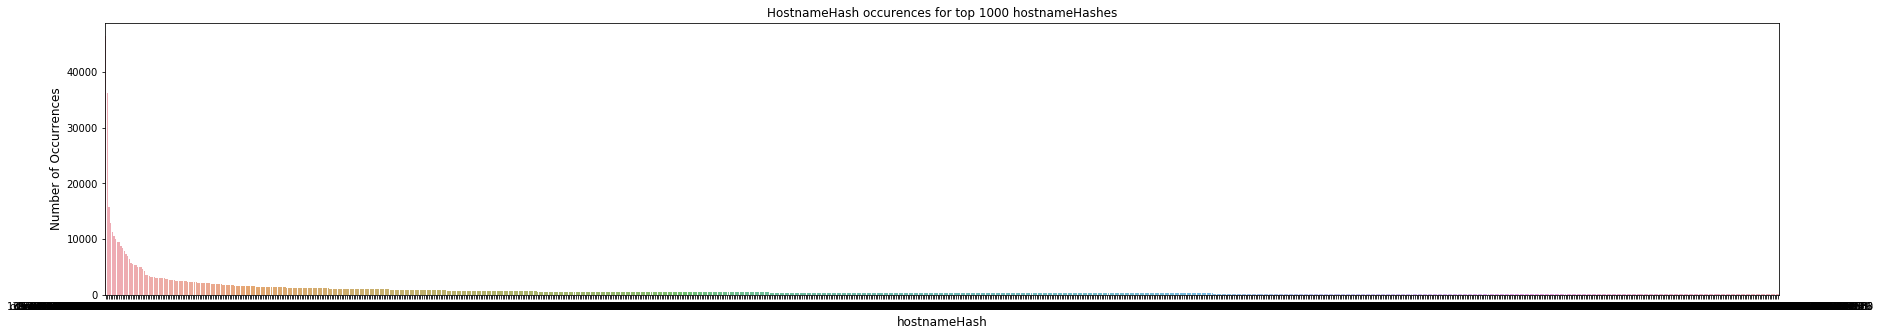

In [11]:
hash_count  = hostnamecounts
hash_count = city_count[:1000,]
plt.figure(figsize=(30,5))
sns.barplot(hash_count.index, hash_count.values, alpha=0.8)
plt.title('HostnameHash occurences for top 1000 hostnameHashes')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('hostnameHash', fontsize=12)
plt.show()

In [8]:
len(df.hostnameHash.value_counts())

15572

In [9]:
df[df['parentPageGuid']=='e998b51a-e117-4e28-8bc2-f3aa52b6cca9']

,hostnameHash,pageGuid,parentPageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
0,7905d1c4e12c54933a44d19fcd5f9356,1a6c0d62-b3b6-4bb2-aaed-f389f7771d60,e998b51a-e117-4e28-8bc2-f3aa52b6cca9,301,d41d8cd98f00b204e9800998ecf8427e,NaN,NaN


In [10]:
df[['hostnameHash','pageGuid','parentPageGuid']].groupby(['hostnameHash']).agg('count')

,pageGuid,parentPageGuid
hostnameHash,,
000704a3e488015d32cc64a86dc32310,0,1
000758a353fa674f968ab5d837170129,13,15
0007f9134e2994a9622699faa03fb446,4,4
000e7c78f3f74a9a932d54887cc6bb4f,2,2
00152d5fbe4125b51f6f9f46b862ecd3,2,3
0018c5469e810975769bd2470233868f,2,2
001d74bb3f28aaed078c549b35420d03,6,6
001dcc1adf7693e8639d1d8132b77a90,2,2
0021e2d1a666100a9ca1d9d99b98a068,79,80


In [21]:
df[df.hostnameHash=='0052f84b3d3109e31f7ed2cfabb0ad00']

,hostnameHash,pageGuid,parentPageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
6407,0052f84b3d3109e31f7ed2cfabb0ad00,8ecd7a13-3b5a-4c0f-93fc-79cbb8a5711c,3b6f6d33-50f6-4eca-ab14-e3d43d073674,472,149827464705bc2bdb95231f75dddb6f,38.0,text/plain
6410,0052f84b3d3109e31f7ed2cfabb0ad00,8ecd7a13-3b5a-4c0f-93fc-79cbb8a5711c,279666f9-38ae-4021-92cf-54e9e244db06,472,149827464705bc2bdb95231f75dddb6f,38.0,text/plain
6420,0052f84b3d3109e31f7ed2cfabb0ad00,8ecd7a13-3b5a-4c0f-93fc-79cbb8a5711c,94a00e27-f66e-40e1-aa55-f4b282d50c3b,200,8b27bc96115c2d24350f0d09e6a9433f,38205.0,application/vnd.ms-fontobject
6421,0052f84b3d3109e31f7ed2cfabb0ad00,8ecd7a13-3b5a-4c0f-93fc-79cbb8a5711c,3c3c1a54-c0c8-4847-b439-67b48f832209,200,8b27bc96115c2d24350f0d09e6a9433f,38205.0,application/vnd.ms-fontobject
6422,0052f84b3d3109e31f7ed2cfabb0ad00,8ecd7a13-3b5a-4c0f-93fc-79cbb8a5711c,ab2f2621-0921-4617-be3e-0339f48bd774,200,3293616ec0c605c7c2db25829a0a509e,44432.0,font/woff
6423,0052f84b3d3109e31f7ed2cfabb0ad00,8ecd7a13-3b5a-4c0f-93fc-79cbb8a5711c,c9b5570f-ba45-4337-b9eb-6883c7504bd7,200,dcb26c7239d850266941e80370e207c1,80652.0,font/ttf
6424,0052f84b3d3109e31f7ed2cfabb0ad00,8ecd7a13-3b5a-4c0f-93fc-79cbb8a5711c,3f22b75c-8d9f-4f30-bdc8-83044b79de7a,200,0a799148a50bb02c6f380eabd8d97559,202148.0,image/svg+xml
10998,0052f84b3d3109e31f7ed2cfabb0ad00,4afacfdd-a241-4526-97bd-206391dac663,88d8f3c3-de2f-456b-8f2e-2d70a1ab77c2,200,bbfef9385083d307ad2692c0cf99f611,20766.0,text/css
10999,0052f84b3d3109e31f7ed2cfabb0ad00,4afacfdd-a241-4526-97bd-206391dac663,643ac269-c96a-4576-bfe6-ea12e55d89f4,200,90186830c9c50a0fed932494581761d9,72449.0,application/vnd.ms-fontobject
11000,0052f84b3d3109e31f7ed2cfabb0ad00,4afacfdd-a241-4526-97bd-206391dac663,949823b0-74cc-4eb8-a647-9504dac335a8,200,90186830c9c50a0fed932494581761d9,72449.0,application/vnd.ms-fontobject


In [76]:
df.groupby('hhostnameHash').nunique()

,hhostnameHash,pageGuid,parentPageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
hhostnameHash,,,,,,,
000704a3e488015d32cc64a86dc32310,1,0,1,1,1,0,1
000758a353fa674f968ab5d837170129,1,2,15,1,12,11,5
0007f9134e2994a9622699faa03fb446,1,2,4,1,1,1,1
000e7c78f3f74a9a932d54887cc6bb4f,1,2,2,1,1,1,1
00152d5fbe4125b51f6f9f46b862ecd3,1,1,3,1,3,1,1
0018c5469e810975769bd2470233868f,1,1,2,1,1,1,1
001d74bb3f28aaed078c549b35420d03,1,6,6,2,6,3,1
001dcc1adf7693e8639d1d8132b77a90,1,2,2,1,1,1,1
0021e2d1a666100a9ca1d9d99b98a068,1,2,80,3,80,80,7


In [79]:
df[df['hhostnameHash']=='003eb7d4255dad4f0c5d7f3f01f2b2ab'].groupby('pageGuid').agg('count')

,hhostnameHash,parentPageGuid,httpResponseCode,responseBodyMD5,responseBodySize,contentType
pageGuid,,,,,,
45c7fe34-bb17-464e-844c-b5c5425fb43a,178,178,178,178,178,178
665f8c77-9c52-4ddd-8c1c-df801a448114,1,1,1,1,1,1


In [88]:
df[df['hhostnameHash'].isnull()]['httpResponseCode'].value_counts()

200    13652
461       17
Name: httpResponseCode, dtype: int64

In [87]:
df['httpResponseCode'].value_counts()

200    857110
302     55733
404     31185
204     16120
470     13824
301      6429
403      4348
400      2758
503      2585
474      1678
429      1563
307      1331
472      1324
0        1273
500       933
303       478
502       332
473       213
410       141
401       122
201        93
471        62
460        53
407        50
202        42
504        40
308        30
405        18
461        17
431        16
414        11
406        10
426        10
505         9
409         8
206         4
520         4
999         4
416         4
462         4
203         4
456         3
445         2
523         2
479         2
508         2
451         2
440         2
422         2
413         2
408         2
719         1
448         1
418         1
415         1
412         1
Name: httpResponseCode, dtype: int64

In [88]:
df.contentType.value_counts()

image/png                                   205131
text/html                                   132661
image/gif                                   118658
image/jpeg                                   75162
text/javascript                              66913
application/javascript                       65428
font/woff2                                   41576
image/svg+xml                                40362
text/css                                     38647
application/x-javascript                     31107
text/plain                                   26699
application/vnd.ms-fontobject                21167
application/octet-stream                     12113
application/font-woff                        10017
font/woff                                     7099
application/json                              7031
image/x-icon                                  5984
application/x-font-ttf                        4890
application/x-font-woff                       4258
font/ttf                       